# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import re
import time
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
#os.environ['CUDA_VISIBLE_DEVICES']='0,1'
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")



/home/dev02/anaconda3/envs/mask_rcnn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES= 5

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
max =0
dirs = os.listdir(os.path.join(os.getcwd(),'../../logs/coco20180518T1056'))
freg = re.compile(r'_\d+')
for dir in dirs:
    number = freg.search(dir)
    if number is not None:
        if int(number.group()[1:])>int(max):
            max =number.group()[1:]
max = '0125'
COCO_MODEL_PATH='/home/dev02/mask_rcnn/logs/coco20180518T1056/mask_rcnn_coco_'+max+'.h5'
model.load_weights(COCO_MODEL_PATH, by_name=True)

/home/dev02/mask_rcnn/logs/coco20180518T1056/mask_rcnn_coco_0125.h5


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
# class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                'bus', 'train', 'truck', 'boat', 'traffic light',
#                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                'teddy bear', 'hair drier', 'toothbrush']

class_names=['BG','fork', 'knife', 'spoon','hotplate']



## Compute ratio

In [5]:

def find_index_of_class(class_ids,class_to_find):
    '''
    find all the index in class_ids given class_to_fidn
    '''
    r = []
    for idx,i in enumerate(class_ids):
        if i == class_to_find:
            r.append(idx)      
    return r

def get_area_of_object(mask,index):
    '''get area with the equivalent index'''
#     print('area in pixel',np.sum(mask[:,:,index]))
    return np.sum(mask[:,:,index])

def find_highest_score(scores,class_indexes):
    max_scores = scores[0]
    max_index=class_indexes[0]
    for i in class_indexes:
        if scores[i] > max_scores:
            max_index = i
    index_left= list(set(class_indexes) - set([max_index]))# index of object that isn't highest
    return [max_index],index_left


def find_highest_iou_mask(masks,hotplate_index,other_objects_index):
    '''
    count all the 1 that union from 2 mask
    '''
    hotplate_mask=masks[:,:,hotplate_index]
    highest_index = other_objects_index[0]
    max_union_score = 0
    object_shape = hotplate_mask.shape
    for i in other_objects_index:
        union_score=0
        object_mask = masks[:,:,i]
        for l in range(object_shape[0]):
            for k in range(object_shape[1]):
                if object_mask[l,k]==1 and hotplate_mask[l,k] ==1:
                    union_score +=1
    #print('union score : {} with score {}'.format(union_score,scores[i]))
        if union_score >max_union_score :
            max_union_score=union_score
            highest_index = i
    return [highest_index],union_score


def find_highest_iou_bb(rois,hotplate_index,other_objects_index):
    highest_index = other_objects_index[0]
    max_iou=0
    for i in other_objects_index:
        iou=compute_iou(rois[hotplate_index[0]],rois[i])

        if iou>max_iou:
            max_iou=iou
            highest_index = i
    return [highest_index]

def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    yA = np.maximum(boxA[0], boxB[0])
    xA = np.maximum(boxA[1], boxB[1])
    yB = np.minimum(boxA[2], boxB[2])
    xB = np.minimum(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def compute_and_compare_dist(point,centroid,max_dist,max_point):
    point = np.asarray(point)
    centroid = np.asarray(centroid)
    dist=np.linalg.norm(point-centroid)
    if dist>max_dist:
        max_dist=dist
        max_point=point
    return max_dist,max_point

def delete_object(class_to_delete,rois,masks,class_ids,scores):
    for i in class_to_delete:
        rois = np.delete(rois,i,0)
        masks = np.delete(masks,i,2)
        class_ids = np.delete(class_ids ,i,0)
        scores = np.delete(scores,i,0)
    return rois ,masks ,class_ids ,scores



def find_length_of_object(object_mask,object_roi):
    centroid = [int(object_roi[0]+(object_roi[2]-object_roi[0])/2) , int(object_roi[1]+(object_roi[3]-object_roi[1])/2)]
    max_dist = 0
    max_point =[0,0]
    #use 2 loop to find the polygon and compute distances
    for i in range(object_mask.shape[0]):
        start = False
        for j in range(object_mask.shape[1]):
            if object_mask[i,j]==1:
                start=True
            if object_mask[i,j]==1 and start and object_mask[i,j-1]==0:
                max_dist,max_point = compute_and_compare_dist([i,j],centroid,max_dist,max_point)

            if object_mask[i,j]==1 and start and object_mask[i,j+1]==0:
                max_dist,max_point = compute_and_compare_dist([i,j],centroid,max_dist,max_point)

    for i in range(object_mask.shape[0]):
        start = False
        for j in range(object_mask.shape[1]):
            if object_mask[i,j]==1:
                start =True
            if object_mask[i,j]==1 and start and object_mask[i-1,j]==0:
                max_dist,max_point = compute_and_compare_dist([i,j],centroid,max_dist,max_point)
            if object_mask[i,j]==1 and start and object_mask[i+1,j]==0:
                max_dist,max_point = compute_and_compare_dist([i,j],centroid,max_dist,max_point)
    # need to double the max_dist because max_dist is from center of object 
    return max_dist*2,max_point,centroid

def get_actual_area(actual_length,length_in_pixel,hotplate_area_in_pixel):
    actual_hotplate_area = (hotplate_area_in_pixel*actual_length**2) / (length_in_pixel**2)
    return actual_hotplate_area
    
def get_ratio_and_refine_hotplate(r):
    '''
    compare the ratio between hotplate and object
    in case detect more than 1 hotplate -> choose the highest score
    '''
    rois = r['rois']
    masks = r['masks'].astype(int)
    class_ids = r['class_ids']
    scores = r['scores']
    if len(class_ids) <=1:
        print('not enough object to compute ratio')
        return r,None
    else:
        hotplate_index = find_index_of_class(class_ids, 4)
        # if there is no hotplate 
        if len(hotplate_index) == 0:
            return r,None
        # if detect more than 1 hotplate
        if len(hotplate_index)>1 :
            hotplate_index,other_index = find_highest_score(scores,hotplate_index)
            r['rois'],r['masks'],r['class_ids'],r['scores'] = delete_object(other_index,rois,masks,class_ids,scores)
            
            
        # find object to compute ratio
        other_objects_index = list(set(range(len(class_ids)))-set(hotplate_index)) 
        if len(other_objects_index)>1 :
            object_index,union_score= find_highest_iou_mask(masks,hotplate_index,other_objects_index)
            # if object mask doesn't inside hotplate, compute by boundingbox
            if union_score == 0:
                object_index = find_highest_iou_bb(rois,hotplate_index,other_objects_index)
        else:
            object_index=other_objects_index
        length,max_point,centroid = find_length_of_object(masks[:,:,object_index],rois[object_index][0])
        
        
        print('object that take to compute ratio:{} with score {}'.format(class_names[class_ids[object_index[0]]],scores[object_index[0]]))
        
        #estimated length of actual objects
        actual_length=0
        if class_ids[object_index[0]] in [1,3]:#fork or spoon
            actual_length=0.2
        elif class_ids[object_index[0]] ==2:#knife
            actual_length=0.30
        
        hotplate_area = get_area_of_object(masks,hotplate_index)
        actual_hotplate_area= get_actual_area(actual_length,length,hotplate_area)
        return r,actual_hotplate_area,max_point,centroid
    

## Run Object Detection

Processing 1 images
image                    shape: (960, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Detect in: 5.077792167663574
object that take to compute ratio:knife with score 0.8571988344192505
hotplate size=0.4228114592658908m2


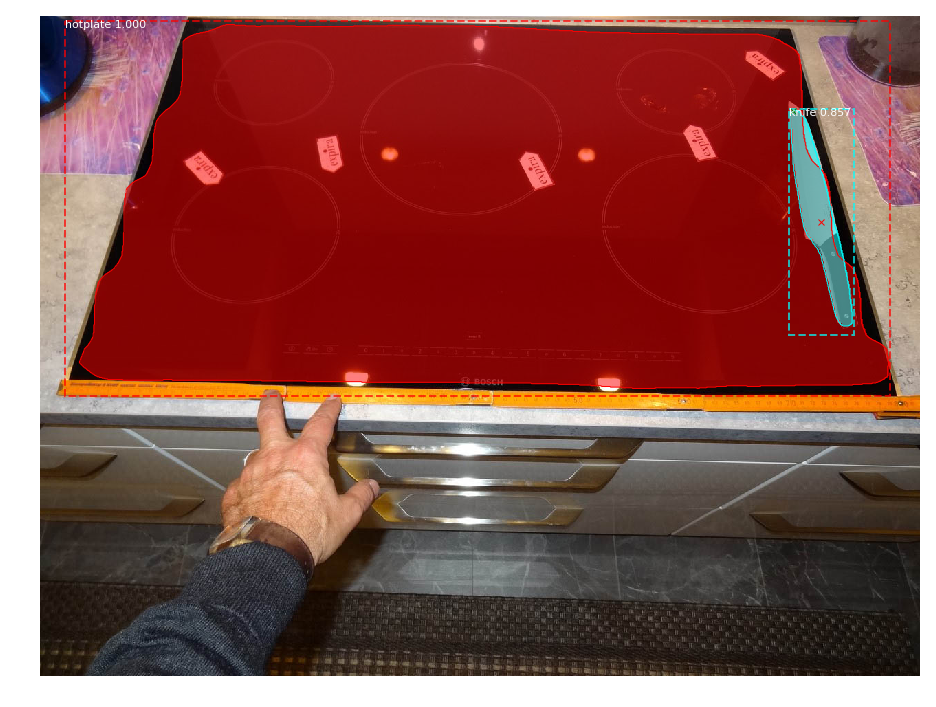

In [6]:
#image to test : use from test1-10
image = skimage.io.imread('/home/dev02/mask_rcnn/test_images/chosen/test10.jpg')
 

#seleceted image : 

# Run detection
start = time.time()
results = model.detect([image], verbose=1)
print('Detect in:',time.time()-start)
# Visualize results
r = results[0]

r ,actual_hotplate_area,max_point,centroid = get_ratio_and_refine_hotplate(r) 

print('hotplate size={}m2'.format(actual_hotplate_area))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'],max_point = max_point,centroid = centroid)